In [1]:
!pip3 install pandas
!pip3 install openpyxl
!pip3 install matplotlib
!pip3 install scipy
!pip3 install scikit-learn
!pip3 install minepy

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app

### Libraries

In [2]:
import os
import json
from datetime import datetime
import pandas as pd
import openpyxl
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import entropy
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel
from sklearn.metrics import mean_squared_error, mean_absolute_error
from collections import defaultdict
from minepy import MINE

# Parameters

In [3]:
current_threshold = 0.1
voltage_threshold = 0.1

### Create Dataframes

#### Files Dictionary

In [4]:
files_dict = {}

def append_sheet(file_name: str, sheet_name: str):
    file_name = file_name.lower()
    sheet_name = sheet_name.lower()
    if not sheet_name.startswith("channel_1"): return
    if file_name not in files_dict:
        files_dict[file_name] = [sheet_name]
    else:
        files_dict[file_name].append(sheet_name)

In [5]:
def is_channel_valid(sheet_name: str):
    sheet_name = sheet_name.lower()
    return sheet_name.startswith("channel_1")

def get_sheetnames(file_name):
    sheet_names = openpyxl.load_workbook(file_name).sheetnames
    return [sheet_name for sheet_name in sheet_names if is_channel_valid(sheet_name)]

In [6]:
def extract_date(date_str):
    parts = date_str.split('.')
    parts = parts[0].split('_')
    month, day, year = map(int, parts[-3:])
    year = year + 2000 if year < 100 else year
    return datetime(year, month, day)

def sort_dates(date_strings):
    return sorted(date_strings, key=extract_date)

#### Cells Dataframe Dictionary

In [7]:
cells_dict = {}

def append_cell(cell: str, df: pd.DataFrame):
    if cell.endswith("/"): cell = cell[:-1]
    cell = cell.split("/")[-1]
    cell = cell.lower()
    if cell not in cells_dict:
        cells_dict[cell] = df
    else:
        cells_dict[cell] = pd.concat([cells_dict[cell], df], axis=0, join='outer', ignore_index=True)
        cells_dict[cell].reset_index(drop=True, inplace=True)

In [8]:
root_folder_mic = "C:\\Users\\Miche\\OneDrive\\Desktop\\UNIVERSITA'\MAGISTRALE\\PRIMO ANNO\\SECONDO SEMESTRE\\MANUTENZIONE\\SOH_RUL_Prediction"
root_folder_max = "/Users/massi/Desktop/University/Manutenzione Preventiva/Progetto/SOH_RUL_Prediction"
root_folder = os.getcwd()
main_folder = "A - CALCE CS2 - Dataset"
folders = ["CS2_3", "CS2_5", "CS2_6", "CS2_7", "CS2_8", "CS2_9", "CS2_21", "CS2_24", "CS2_25", "CS2_33", "CS2_34", "CS2_35", "CS2_36", "CS2_37", "CS2_38"]
allowed_folders = ["CS2_33", "CS2_35", "CS2_36", "CS2_37", "CS2_38"]

In [9]:
for folder in allowed_folders:
    print("Elaborating  on folder: " + folder)
    folder = os.path.join(main_folder, folder)
    file_names = os.listdir(os.path.join(root_folder, folder))
    file_names = sort_dates(file_names)
    start_cycle_index = 0
    for file_name in file_names:
        if file_name.endswith(".xlsx"):
            file_name = os.path.join(folder, file_name)
            sheet_names = get_sheetnames(file_name)
            if len(sheet_names) > 1:
                print(sheet_names)
            for sheet_name in sheet_names:
                df = pd.read_excel(file_name, header=0, sheet_name=sheet_name)
                df["Cycle_Index"] = df["Cycle_Index"] + start_cycle_index
                start_cycle_index = df["Cycle_Index"].max()
                append_cell(folder, df)

Elaborating  on folder: CS2_33
Elaborating  on folder: CS2_35
Elaborating  on folder: CS2_36
Elaborating  on folder: CS2_37
Elaborating  on folder: CS2_38


##### Correzione del dizionario

In [10]:
if False:
    key_updates = {}
    for cell_key in cells_dict.keys():
        key_updates[cell_key] = cell_key.split("/")[-1]
        
    cells_dict = {key_updates.get(key, key): value for key, value in cells_dict.items()}

if True:
    for cell_key in cells_dict.keys():
        cells_dict[cell_key] = cells_dict[cell_key].sort_values(by='Date_Time')


In [11]:
print("Cells count: " + str(len(cells_dict.keys())))

print("Cells name: ", end="")
for cell_key in cells_dict.keys():
    print(cell_key, end=", ")

Cells count: 5
Cells name: cs2_33, cs2_35, cs2_36, cs2_37, cs2_38, 

In [12]:
"""import matplotlib.pyplot as plt

def plot_graph(xSeries: pd.Series, ySeries: pd.Series):
    plt.figure(figsize=(20, 6))
    plt.plot(xSeries, ySeries, marker='', linestyle='-', color='teal')
    plt.xlabel(xSeries.name)
    plt.ylabel(ySeries.name)
    plt.title(ySeries.name + " vs " + xSeries.name)
    plt.grid(True)
    plt.show()
"""

'import matplotlib.pyplot as plt\n\ndef plot_graph(xSeries: pd.Series, ySeries: pd.Series):\n    plt.figure(figsize=(20, 6))\n    plt.plot(xSeries, ySeries, marker=\'\', linestyle=\'-\', color=\'teal\')\n    plt.xlabel(xSeries.name)\n    plt.ylabel(ySeries.name)\n    plt.title(ySeries.name + " vs " + xSeries.name)\n    plt.grid(True)\n    plt.show()\n'

In [13]:
def calc_percentage_removed(old: int, new: int) -> int:
    if old <= 0: return 0
    if new < 0 or new > old: return 0
    length_removed = old - new
    percentage_removed = (length_removed / old) * 100
    return percentage_removed

In [14]:
def remove_outliers(df: pd.DataFrame) -> pd.DataFrame:
    # current
    q1 = df['Current(A)'].quantile(0.25)
    q3 = df['Current(A)'].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    df = df[(df['Current(A)'] >= lower_bound) & (df['Current(A)'] <= upper_bound)]

    # voltage
    q1 = df['Voltage(V)'].quantile(0.25)
    q3 = df['Voltage(V)'].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    df = df[(df['Voltage(V)'] >= lower_bound) & (df['Voltage(V)'] <= upper_bound)]

    # charge capacity
    q1 = df['Charge_Capacity(Ah)'].quantile(0.25)
    q3 = df['Charge_Capacity(Ah)'].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    df = df[(df['Charge_Capacity(Ah)'] >= lower_bound) & (df['Charge_Capacity(Ah)'] <= upper_bound)]

    # discharge capacity
    q1 = df['Discharge_Capacity(Ah)'].quantile(0.25)
    q3 = df['Discharge_Capacity(Ah)'].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    df = df[(df['Discharge_Capacity(Ah)'] >= lower_bound) & (df['Discharge_Capacity(Ah)'] <= upper_bound)]

    return df

In [15]:
def remove_large_difference_outliers(df: pd.DataFrame) -> pd.DataFrame:
    # current
    diff_next = df['Current(A)'].diff(-1).abs()
    diff_prev = df['Current(A)'].diff().abs()
    outliers = (diff_next > current_threshold) | (diff_prev > current_threshold)
    outliers |= outliers.shift(-1, fill_value=False)
    df = df[~outliers]

    # voltage
    diff_next = df['Voltage(V)'].diff(-1).abs()
    diff_prev = df['Voltage(V)'].diff().abs()
    outliers = (diff_next > voltage_threshold) | (diff_prev > voltage_threshold)
    outliers |= outliers.shift(-1, fill_value=False)
    df = df[~outliers]
    return df

In [16]:
def filter(df: pd.DataFrame) -> pd.DataFrame:
    n = len(df)
    df = df[df['Test_Time(s)'] >= 0]

    df = remove_outliers(df)
    df = remove_large_difference_outliers(df)

    max_current_per_cycle = df.groupby('Cycle_Index')['Current(A)'].max()
    max_current_diff = max_current_per_cycle.diff().abs()
    cycle_indices_to_remove = max_current_diff[max_current_diff > 0.1].index.union(max_current_diff[max_current_diff > 0.1].index - 1)
    df = df[~df['Cycle_Index'].isin(cycle_indices_to_remove)]

    m = df["Cycle_Index"].max() # same as "discharge"
    current_current = df['Current(A)'].iloc[0]
    current_voltage = df['Voltage(V)'].iloc[0]
    current_capacity = df['Charge_Capacity(Ah)'].iloc[0]
    current_discapacity = df['Discharge_Capacity(Ah)'].iloc[0]

    df_filter = df
    for cycle in range(m+1):
        df_filter = df
        df_filter = df_filter[df_filter["Cycle_Index"] == cycle]
        if len(df_filter["Test_Time(s)"]) > 0:
            max_current = df_filter[df_filter['Step_Index'].isin([4])]['Current(A)'].max()
            min_current = df_filter[df_filter['Step_Index'].isin([2])]['Current(A)'].min()
            max_voltage = df_filter[df_filter['Step_Index'].isin([4])]['Voltage(V)'].max()
            min_voltage = df_filter[df_filter['Step_Index'].isin([2])]['Voltage(V)'].min()
            max_capacity = df_filter[df_filter['Step_Index'].isin([4])]['Charge_Capacity(Ah)'].max()
            min_capacity = df_filter[df_filter['Step_Index'].isin([2])]['Charge_Capacity(Ah)'].min()
            max_discapacity = df_filter[df_filter['Step_Index'].isin([4])]['Discharge_Capacity(Ah)'].max()
            min_discapacity = df_filter[df_filter['Step_Index'].isin([2])]['Discharge_Capacity(Ah)'].min()
            current = max_current - min_current
            voltage = max_voltage - min_voltage
            capacity = max_capacity - min_capacity
            discapacity = max_discapacity - min_discapacity
            #TODO: adjust thresholds
            if abs(current_current - current) > 1000 or abs(current_voltage - voltage) > 1000 or abs(current_capacity - capacity) > 0.2 or abs(current_discapacity - discapacity) > 1000:
                df = df[df['Cycle_Index'] != cycle]
            current_current = current
            current_voltage = voltage
            current_capacity = capacity
            current_discapacity = discapacity
            
    p = calc_percentage_removed(n, len(df))
    print(f"Removed {n-len(df)} rows per whole dataset ({p}%)")
    return df

def filter_charge(df: pd.DataFrame) -> pd.DataFrame:
    n = len(df)

    df = df[df['Current(A)'] <= 0.555]
    p = calc_percentage_removed(n, len(df))

    print(f"Removed {n-len(df)} rows for charge dataset({p}%)")
    return df

def filter_discharge(df: pd.DataFrame) -> pd.DataFrame:
    n = len(df)
    p = calc_percentage_removed(n, len(df))
    print(f"Removed {n-len(df)} rows for discharge dataset({p}%)")
    return df

In [17]:
def append_subtables(subtables: dict, folder_name: str):
    column_names_charge = ["Date_Time", "Test_Time(s)", "Current(A)", "Voltage(V)", "Charge_Capacity(Ah)", "Cycle_Index", "Step_Index"]
    column_names_discharge = ["Date_Time", "Test_Time(s)", "Current(A)", "Voltage(V)", "Discharge_Capacity(Ah)", "Cycle_Index", "Step_Index"]
    df = cells_dict[folder_name]
    df = filter(df)
    df_charge = df[df['Step_Index'].isin([2, 4])][column_names_charge]
    df_charge = filter_charge(df_charge)
    df_discharge = df[df['Step_Index'].isin([7])][column_names_discharge]
    df_discharge = filter_discharge(df_discharge)
    subtables[folder_name] = {
        "charge": df_charge,
        "discharge": df_discharge
    }

In [18]:
subtables = dict()
for folder in allowed_folders:
    folder = folder.lower()
    append_subtables(subtables, folder)

Removed 71931 rows per whole dataset (22.164395718168205%)
Removed 5807 rows for charge dataset(4.702405053040732%)
Removed 0 rows for discharge dataset(0.0%)
Removed 50230 rows per whole dataset (18.818795567111504%)
Removed 6370 rows for charge dataset(4.4547012133291375%)
Removed 0 rows for discharge dataset(0.0%)
Removed 58806 rows per whole dataset (21.80778473314148%)
Removed 6727 rows for charge dataset(4.789979991312954%)
Removed 0 rows for discharge dataset(0.0%)
Removed 65952 rows per whole dataset (22.664073292599948%)
Removed 7237 rows for charge dataset(4.845275237342832%)
Removed 0 rows for discharge dataset(0.0%)
Removed 62104 rows per whole dataset (20.47643383504509%)
Removed 6639 rows for charge dataset(4.178993617262347%)
Removed 0 rows for discharge dataset(0.0%)


/var/folders/cc/4s4lvm094gdbcql9cn_k0q3m0000gn/T/ipykernel_3786/1675406887.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_charge["Test_Time(s)"] = df_charge["Test_Time(s)"] - first_time
/var/folders/cc/4s4lvm094gdbcql9cn_k0q3m0000gn/T/ipykernel_3786/1675406887.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_charge["Test_Time(s)"] = df_charge["Test_Time(s)"] - first_time


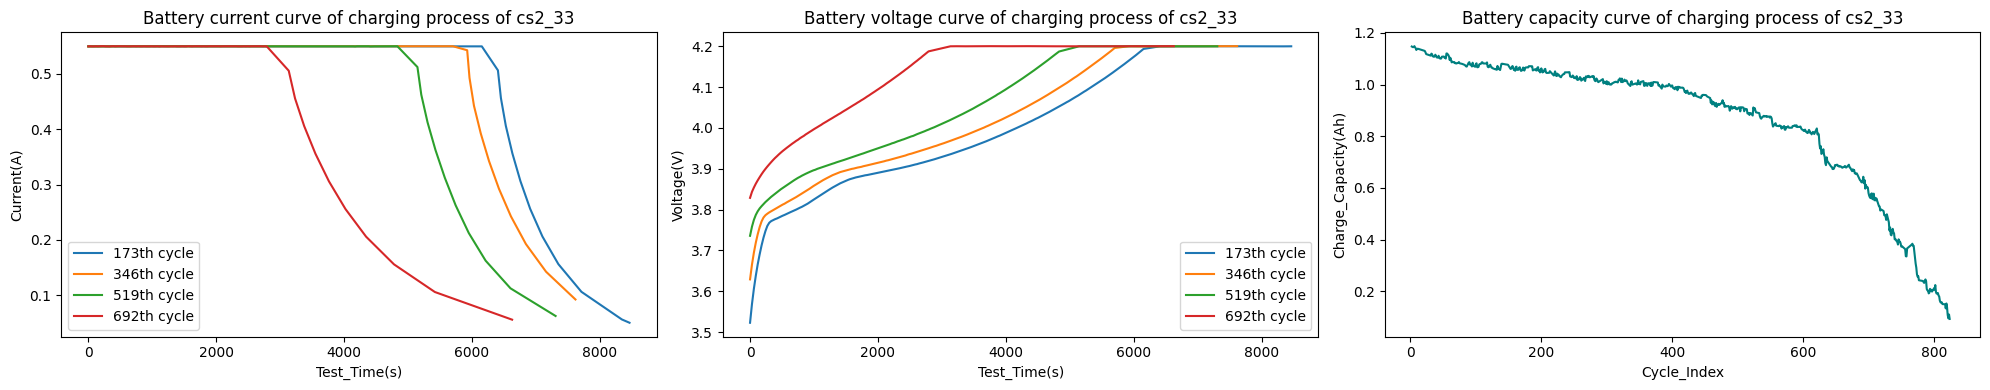

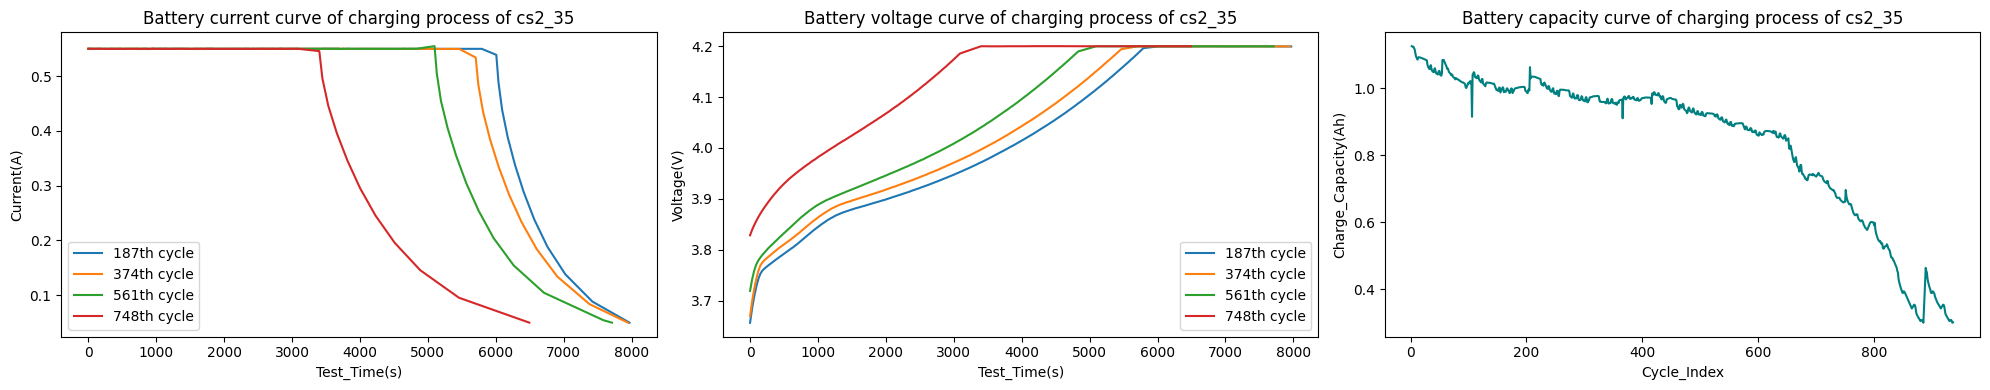

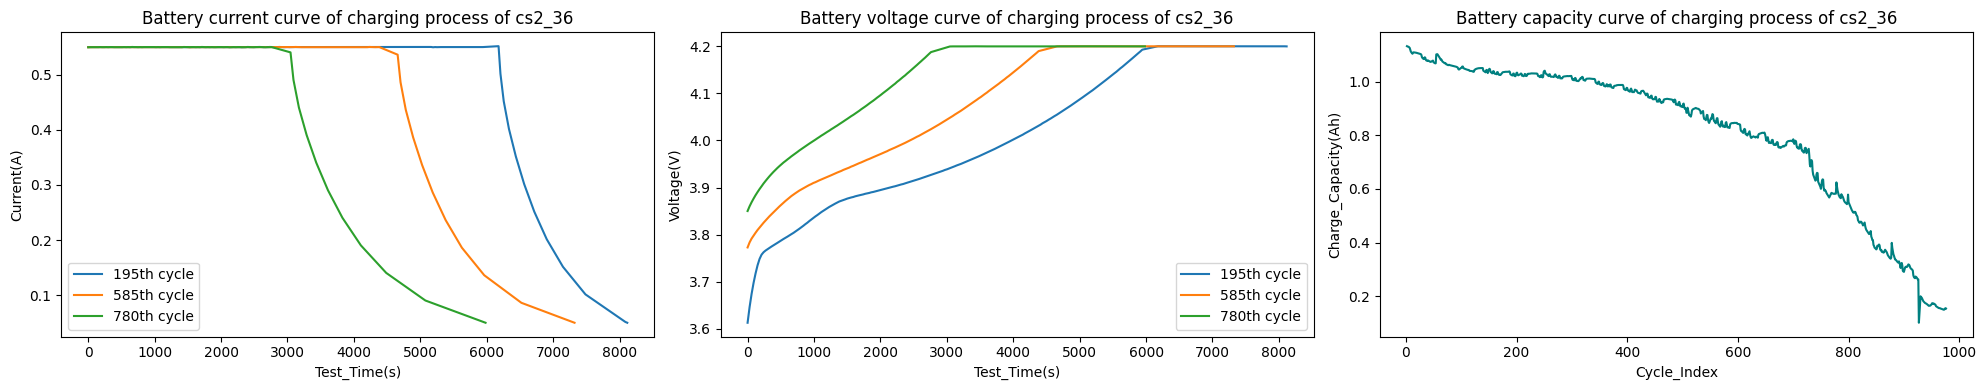

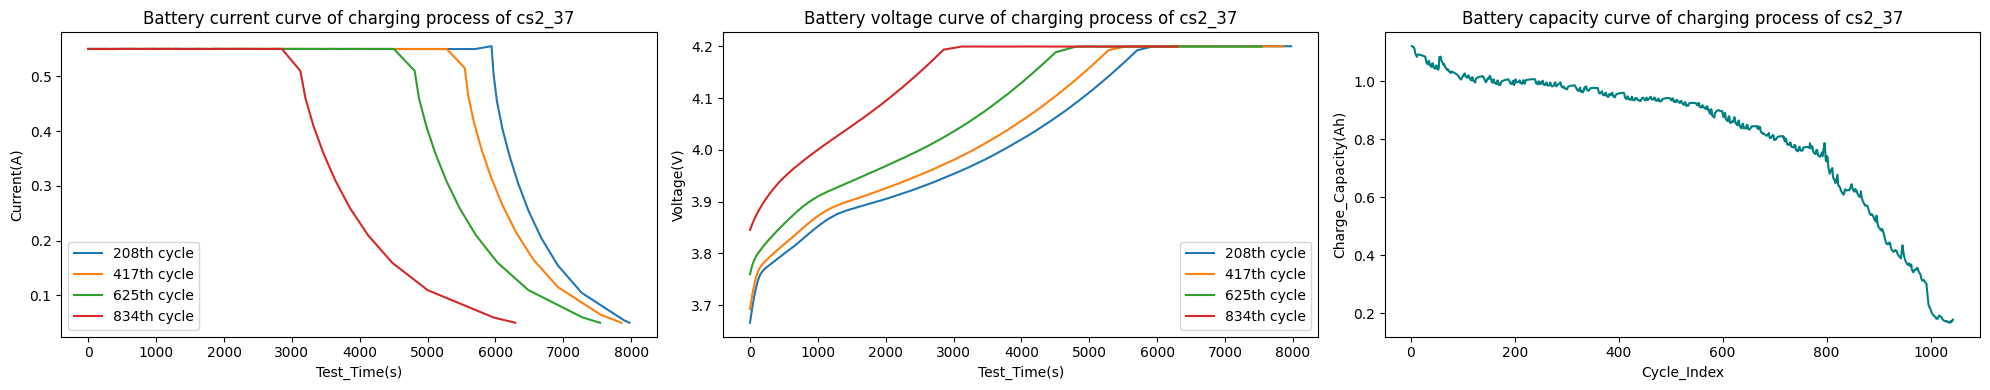

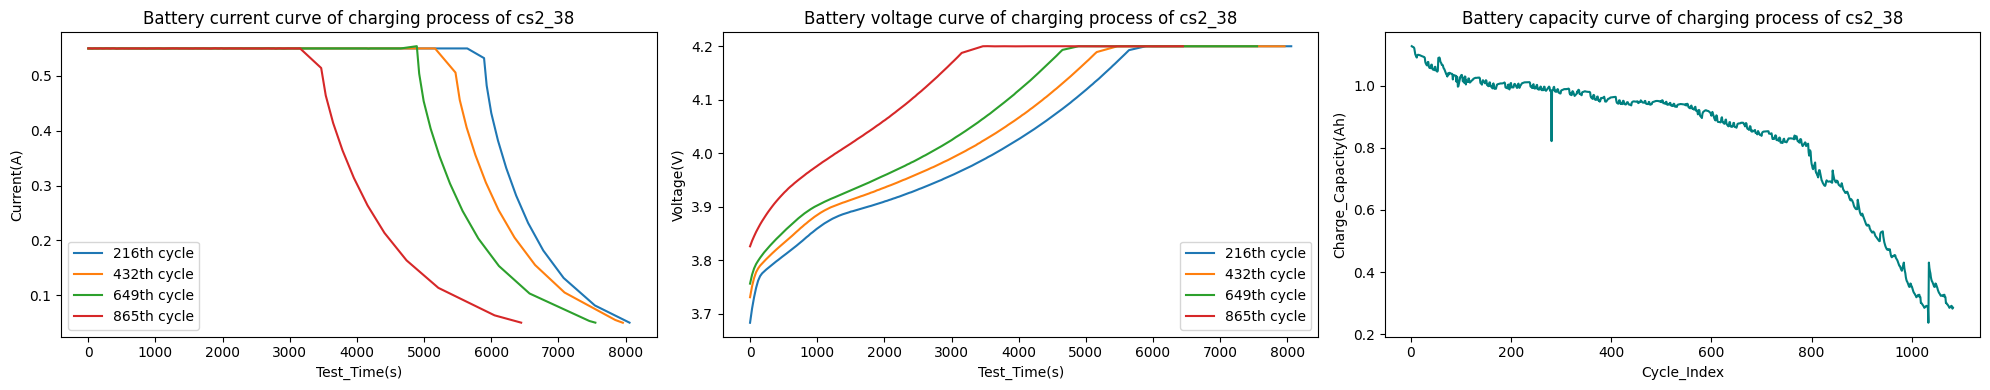

In [19]:
capacities = defaultdict(dict)

for key, value in subtables.items():
    m = value["charge"]["Cycle_Index"].max() # same as "discharge"
    percs = [int(m * percentage) for percentage in [0.2, 0.4, 0.6, 0.8]]
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))

    for perc in percs:
        df_charge = value["charge"]
        df_charge = df_charge[df_charge["Cycle_Index"] == perc]
        if len(df_charge["Test_Time(s)"]) > 0:
            first_time = df_charge["Test_Time(s)"].iloc[0]
            df_charge["Test_Time(s)"] = df_charge["Test_Time(s)"] - first_time
            ax1.plot(df_charge["Test_Time(s)"], df_charge["Current(A)"], label=f'{perc}th cycle', marker='', linestyle='-')
    ax1.set_title(f'Battery current curve of charging process of {key}')
    ax1.set_ylabel('Current(A)')
    ax1.set_xlabel('Test_Time(s)')
    ax1.legend(loc='lower left')

    for perc in percs:
        df_charge = value["charge"]
        df_charge = df_charge[df_charge["Cycle_Index"] == perc]
        if len(df_charge["Test_Time(s)"]) > 0:
            first_time = df_charge["Test_Time(s)"].iloc[0]
            df_charge["Test_Time(s)"] = df_charge["Test_Time(s)"] - first_time
            ax2.plot(df_charge["Test_Time(s)"], df_charge["Voltage(V)"], label=f'{perc}th cycle', marker='', linestyle='-')
    ax2.set_title(f'Battery voltage curve of charging process of {key}')
    ax2.set_ylabel('Voltage(V)')
    ax2.set_xlabel('Test_Time(s)')
    ax2.legend(loc='lower right')

    cycles = []
    current_capacity = 1.2
    for cycle in range(m+1):
        df_charge = value["charge"]
        df_charge = df_charge[df_charge["Cycle_Index"] == cycle]
        if len(df_charge["Test_Time(s)"]) > 0:
            max_capacity = df_charge[df_charge['Step_Index'].isin([4])]['Charge_Capacity(Ah)'].max()
            min_capacity = df_charge[df_charge['Step_Index'].isin([2])]['Charge_Capacity(Ah)'].min()
            capacity = max_capacity - min_capacity
            cycles.append(cycle)
            capacities[key][cycle] = capacity
            current_capacity = capacity
    ax3.plot(capacities[key].keys(), capacities[key].values(), marker='', linestyle='-', color='teal')
    ax3.set_title(f'Battery capacity curve of charging process of {key}')
    ax3.set_ylabel('Charge_Capacity(Ah)')
    ax3.set_xlabel('Cycle_Index')

    plt.tight_layout()
    plt.show()

In [20]:
def normalize_dict(d: dict) -> dict:
    m = max(d.values())
    if m < 0: m = min(d.values())
    for key, value in d.items():
        d[key] = value / m
    d = clean_dict(d)
    return d

def clean_dict(d: dict) -> dict:
    d_ret = dict()
    current_value = 0
    for key, value in d.items():
        if key > 0:
            if abs(value - current_value) < 0.2:
                d_ret[key] = value
        else: 
            d_ret[key] = value
        current_value = value
    return d_ret

def func(x, a, b, c):
    return a + b * np.exp(-c / x)


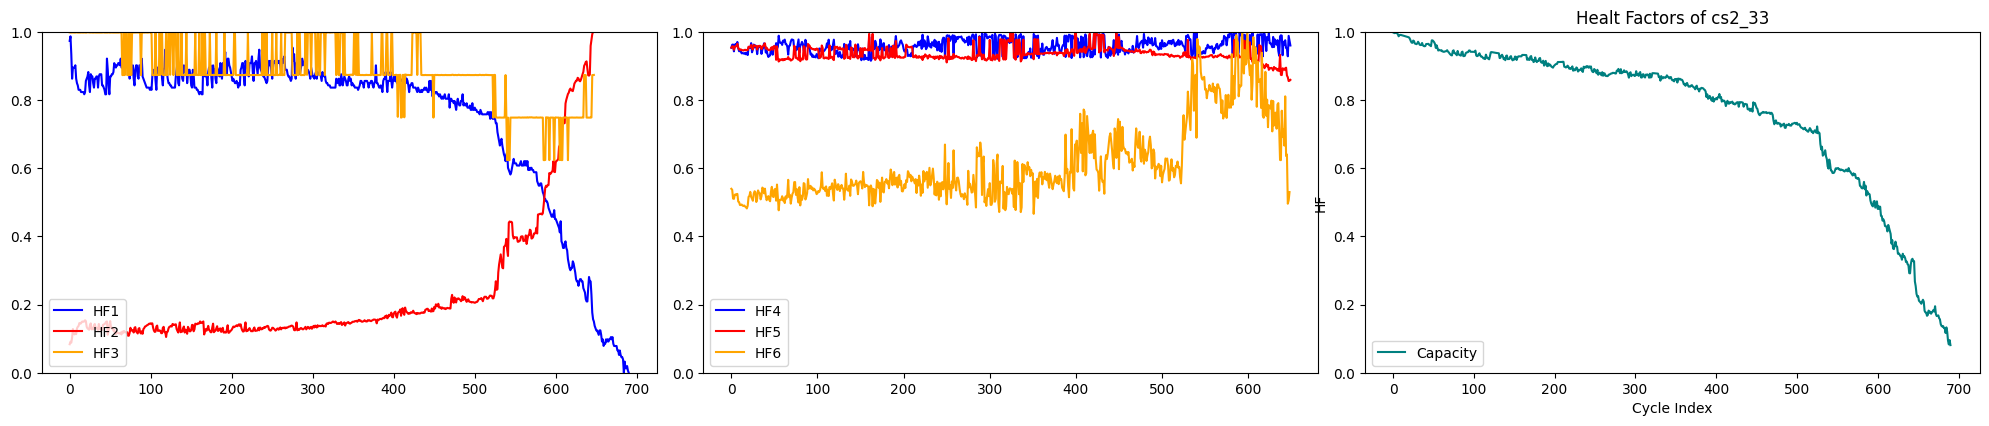

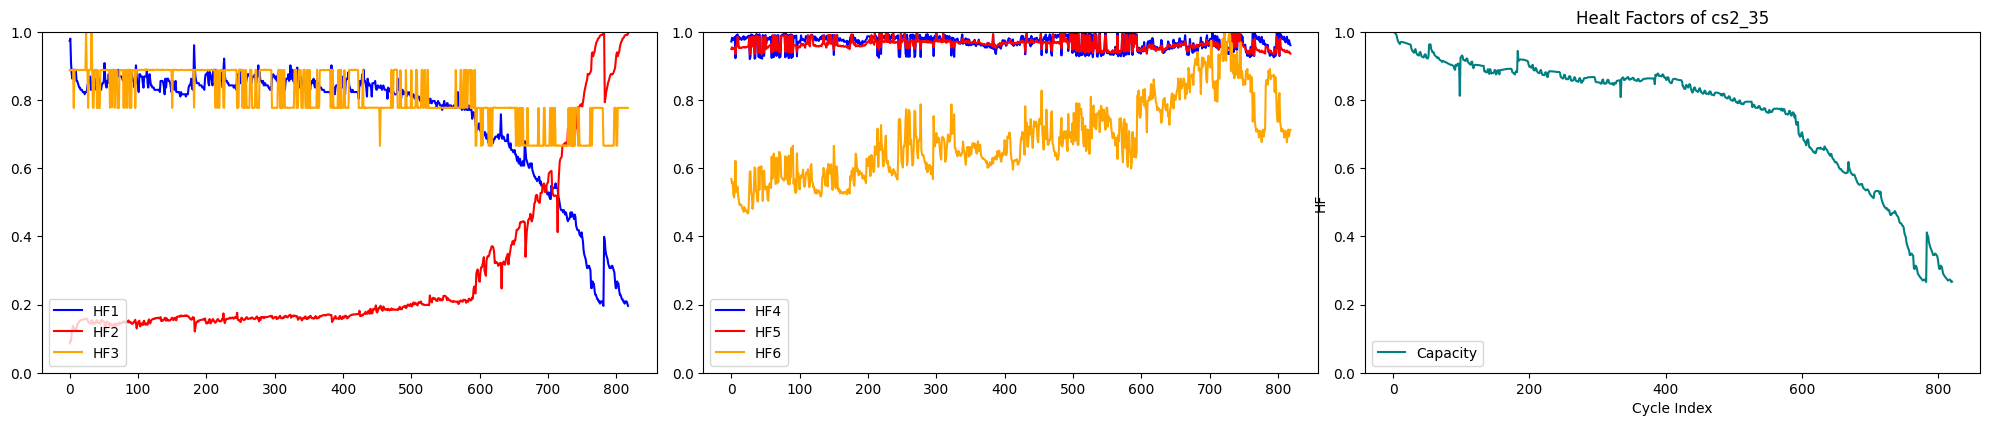

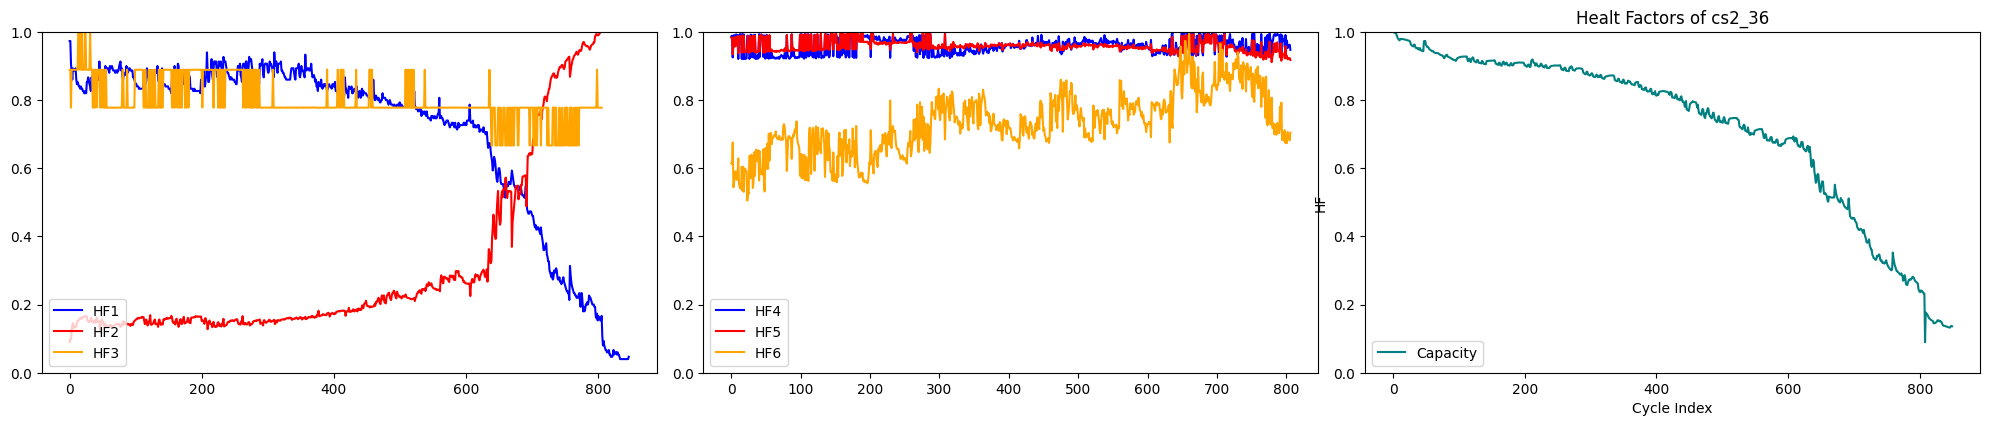

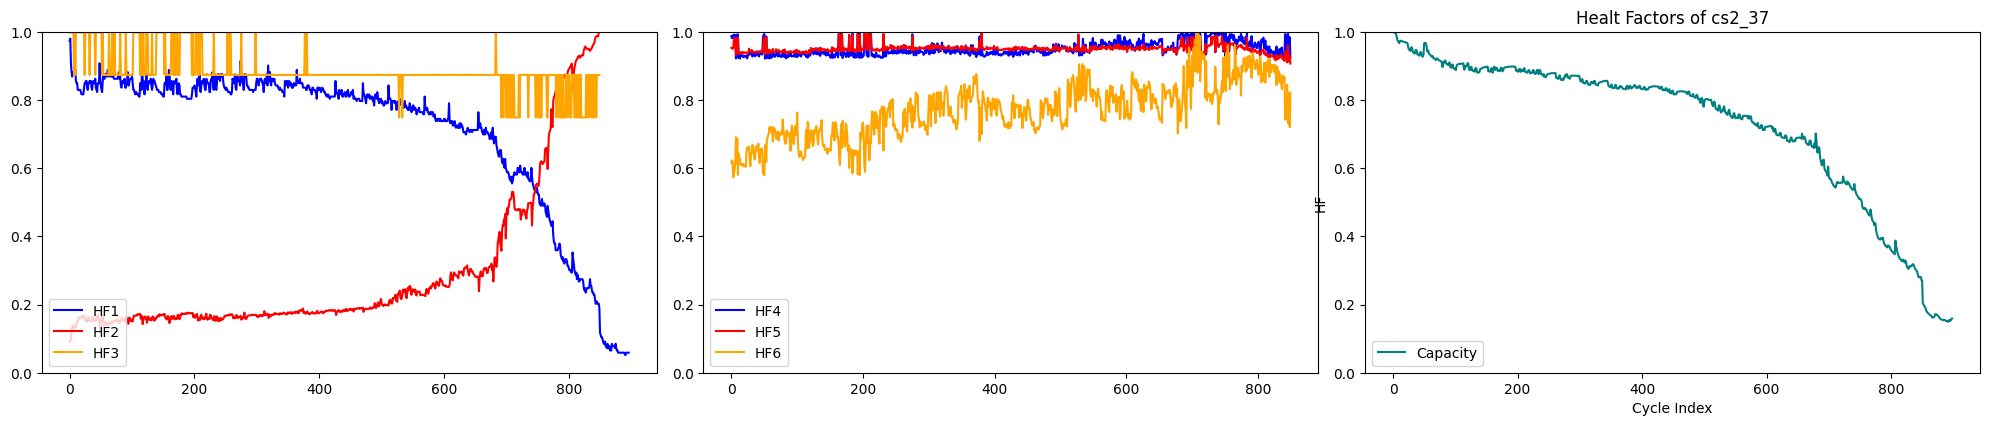

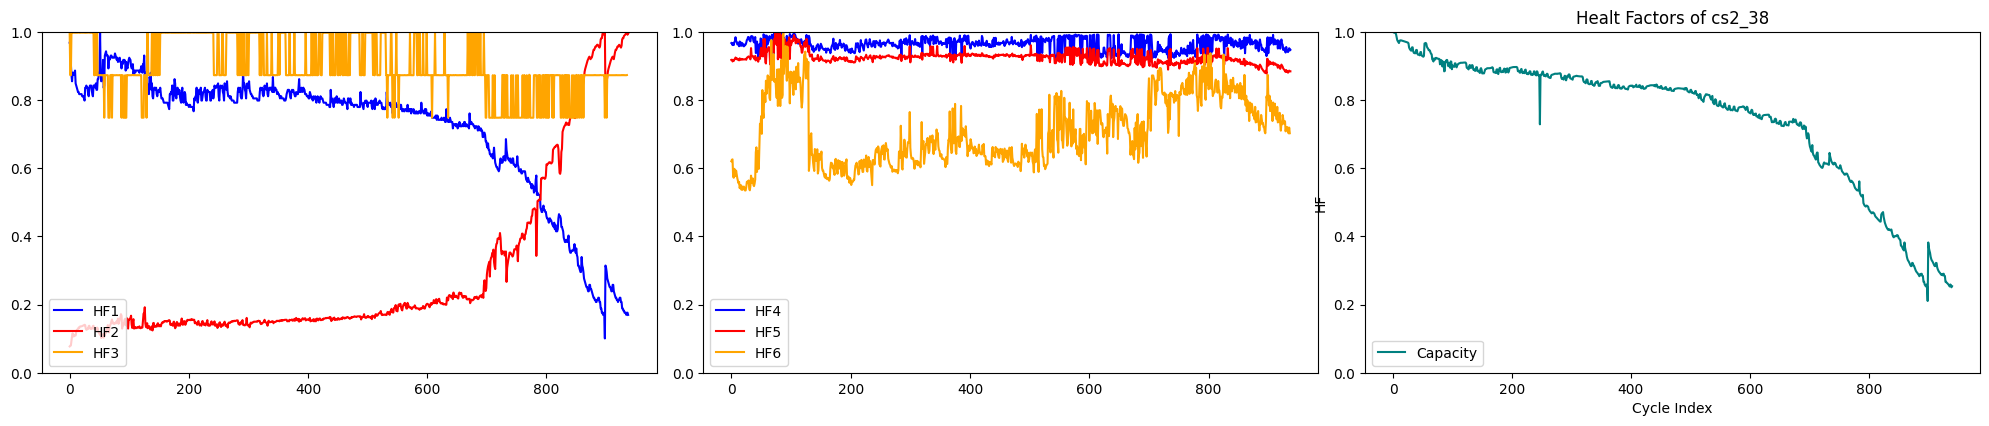

In [21]:
target_voltage_1 = 3.9
target_voltage_2 = 4.2
time_voltage_increase_threshold = 600
time_current_reduction_threshold = 900
hf1s = dict()
hf2s = dict()
hf3s = dict()
hf4s = dict()
hf5s = dict()
hf6s = dict()
#capacities = dict()
for key, value in subtables.items():
    hf1s.clear()
    hf2s.clear()
    hf3s.clear()
    hf4s.clear()
    hf5s.clear()
    hf6s.clear()
    #capacities.clear()
    m = value["charge"]["Cycle_Index"].max()
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))
    for cycle_index in range(m):
        df_charge = value["charge"]
        df_charge_cc = df_charge[(df_charge["Cycle_Index"] == cycle_index) & (df_charge['Step_Index'].isin([2]))].copy()
        df_charge_cv = df_charge[(df_charge["Cycle_Index"] == cycle_index) & (df_charge['Step_Index'].isin([4]))].copy()
        series_3_9 = df_charge_cc.iloc[(df_charge_cc['Voltage(V)'] - target_voltage_1).abs().argsort()[:1]]
        series_4_2 = df_charge_cc.iloc[(df_charge_cc['Voltage(V)'] - target_voltage_2).abs().argsort()[:1]]
        series_enter_cv = df_charge_cv[:1]
        datetime_3_9 = series_3_9["Date_Time"]
        datetime_4_2 = series_4_2["Date_Time"]
        datetime_enter_cv = series_enter_cv["Date_Time"]
        if datetime_3_9.empty or datetime_4_2.empty or series_enter_cv.empty or pd.isna(datetime_3_9.iloc[0]) or pd.isna(datetime_4_2.iloc[0]) or pd.isna(datetime_enter_cv.iloc[0]) or len(df_charge_cv["Current(A)"]) == 0:
            time_difference = float('nan')
            voltage_difference = float('nan')
            current_reduction = float('nan')
        else:
            time_difference_delta = datetime_4_2.iloc[0] - datetime_3_9.iloc[0]
            time_difference = float(time_difference_delta.total_seconds())
            hf1s[cycle_index] = time_difference
            time_voltage_threshold = datetime_3_9.iloc[0] + pd.Timedelta(seconds=time_voltage_increase_threshold)
            time_current_threshold = datetime_enter_cv.iloc[0] + pd.Timedelta(seconds=time_current_reduction_threshold)
            if df_charge_cc['Date_Time'].max() >= time_voltage_threshold and df_charge_cv['Date_Time'].max() >= time_current_threshold:
                df_voltage_increase = df_charge_cc[df_charge_cc['Date_Time'] >= time_voltage_threshold].iloc[0]
                voltage_difference = df_voltage_increase['Voltage(V)'] - series_3_9['Voltage(V)']
                hf2s[cycle_index] = float(voltage_difference.iloc[0])
                df_current_reduction = df_charge_cv[df_charge_cv['Date_Time'] >= time_current_threshold].iloc[0]
                current_difference = series_enter_cv['Current(A)'] - df_current_reduction['Current(A)']
                hf3s[cycle_index] = float(current_difference.iloc[0])
                df_charge_cv.loc[:, 'Time_Secs'] = (df_charge_cv['Date_Time'] - df_charge_cv['Date_Time'].min()).dt.total_seconds()
                #max_capacity = df_charge_cv['Charge_Capacity(Ah)'].max()
                #min_capacity = df_charge_cv['Charge_Capacity(Ah)'].min()
                #capacity = max_capacity - min_capacity
                #capacities[cycle_index] = capacity
                try:
                    popt, _ = curve_fit(func, df_charge_cv['Time_Secs'], df_charge_cv["Current(A)"])
                    hf4s[cycle_index], hf5s[cycle_index], hf6s[cycle_index] = popt
                except Exception:
                    print("Warning: Anomaly for a value")


    hf1s = normalize_dict(hf1s)
    hf2s = normalize_dict(hf2s)
    hf3s = normalize_dict(hf3s)
    hf4s = normalize_dict(hf4s)
    hf5s = normalize_dict(hf5s)
    hf6s = normalize_dict(hf6s)
    caps = normalize_dict(capacities[key])
    subtables[key]["hfs"] = {
        "hf1s": hf1s.values(),
        "hf2s": hf2s.values(),
        "hf3s": hf3s.values(),
        "hf4s": hf4s.values(),
        "hf5s": hf5s.values(),
        "hf6s": hf6s.values(),
        "capacities": caps.values()
    }
    ax1.plot(hf1s.values(), label='HF1', marker='', linestyle='-', color='blue')
    ax1.plot(hf2s.values(), label='HF2', marker='', linestyle='-', color='red')
    ax1.plot(hf3s.values(), label='HF3', marker='', linestyle='-', color='orange')
    ax1.set_ylim(0, 1)
    ax1.legend(loc="lower left")
    ax2.plot(hf4s.values(), label='HF4', marker='', linestyle='-', color='blue')
    ax2.plot(hf5s.values(), label='HF5', marker='', linestyle='-', color='red')
    ax2.plot(hf6s.values(), label='HF6', marker='', linestyle='-', color='orange')
    ax2.set_ylim(0, 1)
    ax2.legend(loc="lower left")
    ax3.plot(capacities[key].values(), label='Capacity', marker='', linestyle='-', color='teal')
    ax3.legend(loc="lower left")
    ax3.set_ylim(0, 1)

    plt.tight_layout()
    plt.title((f'Healt Factors of {key}'))
    plt.ylabel("HF")
    plt.xlabel("Cycle Index")
    plt.show()

HF1 - Capacity:  0.8957696602602908
HF2 - Capacity:  0.9929398841087131
HF3 - Capacity:  0.4657034636049917
HF4 - Capacity:  0.3852307352112027
HF5 - Capacity:  0.414390431080521
HF6 - Capacity:  0.7283207504570299


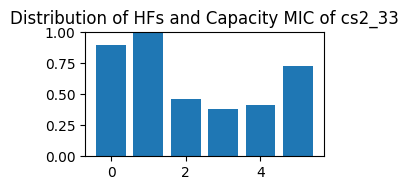

HF1 - Capacity:  0.9177997325556387
HF2 - Capacity:  0.9780305075191658
HF3 - Capacity:  0.3260675101048895
HF4 - Capacity:  0.34477096936258855
HF5 - Capacity:  0.3534722426868412
HF6 - Capacity:  0.6341016425094198


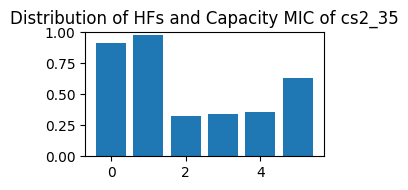

HF1 - Capacity:  0.956479750677845
HF2 - Capacity:  0.9999989992415563
HF3 - Capacity:  0.3142346194023057
HF4 - Capacity:  0.42422272901473007
HF5 - Capacity:  0.3669600999260968
HF6 - Capacity:  0.6391769083363062


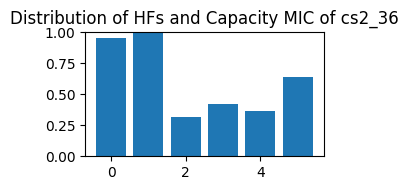

HF1 - Capacity:  0.9142211855325288
HF2 - Capacity:  0.9795459453134489
HF3 - Capacity:  0.34163886633998
HF4 - Capacity:  0.297448678796851
HF5 - Capacity:  0.5061701914923484
HF6 - Capacity:  0.704096890540658


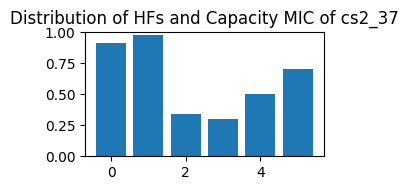

HF1 - Capacity:  0.8935605451278784
HF2 - Capacity:  0.9541238544699406
HF3 - Capacity:  0.3549092582884862
HF4 - Capacity:  0.33492676994484194
HF5 - Capacity:  0.5654562146526114
HF6 - Capacity:  0.720808231528697


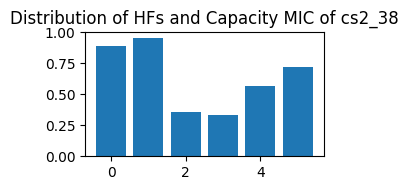

In [22]:
mic_threshold = 0.6

def calculate_mic(x, y):
    mine = MINE(alpha=0.6, c=15)
    mine.compute_score(x, y)
    return mine.mic()

def resize_array(long_array, target_length):
    if len(long_array) > target_length:
        indices_to_remove = np.round(np.linspace(0, len(long_array) - 1, len(long_array) - target_length)).astype(int)
        return np.delete(long_array, indices_to_remove).tolist()
    
dataset = dict()

for j, (key, value) in enumerate(subtables.items()):
    dataset[key] = pd.DataFrame()
    hfs = value["hfs"]
    hfss = [hfs["hf1s"], hfs["hf2s"], hfs["hf3s"], hfs["hf4s"], hfs["hf5s"], hfs["hf6s"]]
    mics = dict()
    capacities = [c for c in hfs["capacities"] if c is not None]
    """max_length = max(len(hfss[0]), len(hfss[1]), len(hfss[2]), len(hfss[3]), len(hfss[4]), len(hfss[5]), len(capacities))
    df = pd.DataFrame({'hf1s': pd.Series(hfss[0]),
                   'hf2s': pd.Series(hfss[1]),
                   'hf3s': pd.Series(hfss[2]),
                   'hf4s': pd.Series(hfss[3]),
                   'hf5s': pd.Series(hfss[4]),
                   'hf6s': pd.Series(hfss[5]),
                   'capacities': pd.Series(capacities)}).reindex(range(max_length))"""

    for i, hf in enumerate(hfss):
        if len(list(hf)) > len(capacities):
            hf = resize_array(list(hf), len(capacities))
            caps = capacities
        else: 
            caps = resize_array(capacities, len(list(hf)))
        mic = calculate_mic(list(hf), caps)
        mics[i] = mic
        print(f"HF{i+1} -", "Capacity: ", mic)
        if mic > mic_threshold:
            series = pd.Series(hf, name=f'HF{i+1}')
            dataset[key][f'HF{i+1}'] = series
    series = pd.Series(caps, name='Capacities')
    dataset[key]['Capacities'] = series
    plt.figure(figsize=(3, 2))
    plt.bar(mics.keys(), mics.values())
    plt.title(f"Distribution of HFs and Capacity MIC of {key}")
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()


# Gaussian Process Regression

In [125]:
k = 20 # 20 35 50
c = 300 # 100 200 300 400

df = pd.DataFrame()

def translate_series(series, positions):
    translated_series = series.copy()
    for i in range(len(series)):
        new_index = i + positions
        if new_index < len(series):
            translated_series[i] = series[new_index]
        else:
            translated_series[i] = np.nan
    return translated_series

for key, value in dataset.items():
    df_hf = dataset[key]
    df_hf = df_hf[~df_hf.isna().any(axis=1)]
    df_hf = df_hf[df_hf['Capacities'] >= 0.75]
    df_hf = df_hf.reset_index(drop=True)
    #df_hf['Capacities'] = (df_hf['Capacities'] - 0.8) / 0.2
    if key != "cs2_38":
        df_hf['Capacities'] = translate_series(df_hf['Capacities'], k)
        df_hf = df_hf.dropna()
        df = pd.concat([df, df_hf], axis=0, join='outer', ignore_index=True)
        df.reset_index(drop=True, inplace=True)
    else:
        df_hf['Capacities'] = translate_series(df_hf['Capacities'], k)
        df_hf = df_hf.dropna()
        X_test = df_hf.drop('Capacities', axis=1)
        y_test = df_hf['Capacities'].dropna()

X_train = df.drop('Capacities', axis=1)
y_train = df['Capacities']

"""scaler = StandardScaler()
scaler.fit(X_train)
X_scaled = scaler.transform(X_train)
y_scaled = scaler.transform(y_train)"""

'scaler = StandardScaler()\nscaler.fit(X_train)\nX_scaled = scaler.transform(X_train)\ny_scaled = scaler.transform(y_train)'

In [126]:
theta_0 = ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-3, 1e3))
noise_level = 1.0
kernel = theta_0 * RBF() + WhiteKernel(noise_level=noise_level)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

gp.fit(X_train, y_train)
y_pred, sigma = gp.predict(X_test[:c], return_std=True)

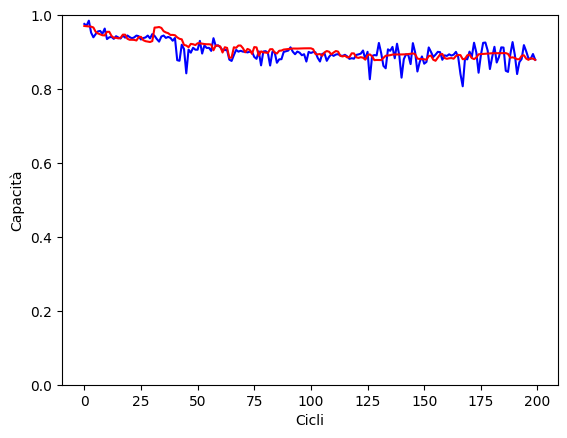

In [127]:
plt.plot(y_pred, color="blue")
plt.plot(y_test[:c], color="red")
plt.ylim(0, 1)
plt.ylabel("Capacità")
plt.xlabel("Cicli")
plt.show()

In [122]:
def find_end_cycle(ys: list, n: int):
    if len(ys) < n:
        raise Exception(f"Input has < {n} elements")
    for i in range(len(ys) - (n-1)):
        elems = ys[i:i+n]
        average = sum(elems) / n
        if average < 0.8:
            for j, y in enumerate(ys[i:i+n]):
                if y < 0.8: return i+j
            return 
    raise Exception("No triplet found")

In [128]:
mse = mean_squared_error(y_test[:c], y_pred)
mae = mean_absolute_error(y_test[:c], y_pred)
rmse = np.average(np.sqrt(mse))
print("MSE:", mse, "MAE:", mae, "RMSE:", rmse)

try:
    print("Known HFs after", c, "cycles:")
    print(" True SOH at cicle", str(c + k), "is", str(y_test[c-1]))
    print(" Pred SOH at cicle", str(c + k), "is", str(y_pred[c-1]))
    #print(" True RUL:", find_end_cycle(y_test, 5) + k, "cycles")
    #print(" Pred RUL:", find_end_cycle(y_pred, 5) + k, "cycles")
except Exception as e:
    raise e

MSE: 0.00043389626703631073 MAE: 0.015013192281789278 RMSE: 0.020830176836414777
Known HFs after 200 cycles:
 True SOH at cicle 220 is 0.8790371955332273
 Pred SOH at cicle 220 is 0.8790621815578678
